In [1]:
# 加载模块，初始化数据
from __future__ import division

%matplotlib inline

import tushare as ts
import pandas as pd
import numpy as np

data = ts.get_hist_data('510050', '2017-01-01')
data = data.sort_index()
df = pd.DataFrame()
df['close'] = data['close']
df['change'] = df['close'] - df['close'].shift(1)
df = df.dropna()
df

,close,change
date,,
2017-01-04,2.33,0.02
2017-01-05,2.32,-0.01
2017-01-06,2.31,-0.01
2017-01-09,2.32,0.01
2017-01-10,2.31,-0.01
2017-01-11,2.30,-0.01
2017-01-12,2.30,0.00
2017-01-13,2.31,0.01
2017-01-16,2.34,0.03


In [5]:
# 定义数据缓存结构
close5_array = np.zeros(5)      # MA5 缓存数组
close20_array = np.zeros(20)    # MA20 缓存数组
last_signal = 0                 # 最近的交易信号，初始化为0
last_pos = 0                    # 最近的持仓，初始化为0

dr_list = []

class DailyResult:
    '''每日盈亏结果'''
    def __init__(self):
        '''构造函数，初始化成员变量'''
        self.date = ''      # 日期
        self.close = 0      # 当日收盘
        self.change = 0     # 当日涨跌
        self.pos = 0        # 当日持仓
        self.last_pos = 0   # 昨日持仓

        self.pnl = 0        # 当日盈亏
        self.fee = 0        # 当日手续费
        self.net_pnl = 0    # 当日净盈亏

    def calculate(self, date, close, change, last_signal, last_pos):
        '''计算每日盈亏'''
        # 赋值原始数据
        self.date = date
        self.close = close
        self.change = change
        self.pos = last_signal
        self.last_pos = last_pos

        # 计算结果数据
        self.pnl = self.change * self.pos
        self.fee = abs(self.pos - self.last_pos) * 1.5 / 10000
        self.net_pnl = self.pnl - self.fee


In [6]:
# 运行回测
for i, row in enumerate(df.iterrows()):
    date = row[0]
    close = row[1]['close']
    change = row[1]['change']

    # 将数组中的老数据移一格
    close5_array[0:4] = close5_array[1:5]
    close20_array[0:19] = close20_array[1:20]

    # 将新数据添加到数组末尾
    close5_array[-1] = close
    close20_array[-1] = close

    # 如果尚未有20个数据点的缓存数量，则不执行后续逻辑
    if i < 20:
        continue

    # 计算当日持仓盈亏
    dr = DailyResult()
    dr.calculate(date, close, change, last_signal, last_pos)

    print('%s\t%f\t%f\t%d\t%f\t%f\t%f' % 
          (dr.date, dr.close, dr.change, dr.pos, dr.pnl, dr.fee, dr.net_pnl))
    
    # 保存计算结果到列表中
    dr_list.append(dr)

    # 记录当日持仓
    last_pos = dr.pos

    # 计算信号数据
    ma5 = close5_array.mean()
    ma20 = close20_array.mean()
    if ma5 >= ma20:
        last_signal = 10000
    else:
        last_signal = -10000


2017-02-08	2.350000	0.010000	0	0.000000	0.000000	0.000000
2017-02-09	2.350000	0.000000	10000	0.000000	1.500000	-1.500000
2017-02-10	2.370000	0.020000	10000	200.000000	0.000000	200.000000
2017-02-13	2.380000	0.010000	10000	100.000000	0.000000	100.000000
2017-02-14	2.370000	-0.010000	10000	-100.000000	0.000000	-100.000000
2017-02-15	2.370000	0.000000	10000	0.000000	0.000000	0.000000
2017-02-16	2.370000	0.000000	10000	0.000000	0.000000	0.000000
2017-02-17	2.360000	-0.010000	10000	-100.000000	0.000000	-100.000000
2017-02-20	2.400000	0.040000	10000	400.000000	0.000000	400.000000
2017-02-21	2.390000	-0.010000	10000	-100.000000	0.000000	-100.000000
2017-02-22	2.400000	0.010000	10000	100.000000	0.000000	100.000000
2017-02-23	2.390000	-0.010000	10000	-100.000000	0.000000	-100.000000
2017-02-24	2.390000	0.000000	10000	0.000000	0.000000	0.000000
2017-02-27	2.370000	-0.020000	10000	-200.000000	0.000000	-200.000000
2017-02-28	2.370000	0.000000	10000	0.000000	0.000000	0.000000
2017-03-01	2.370000	0.

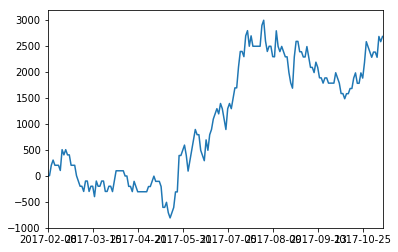

In [7]:
# 显示回测结果
result_df = pd.DataFrame()
result_df['net_pnl'] = [dr.net_pnl for dr in dr_list]   # 将DailyResult列表中的数据转换为
result_df.index = [dr.date for dr in dr_list]           # 添加日期索引

result_df['cum_pnl'] = result_df['net_pnl'].cumsum()    # 累积求和
#print('%s\t%f\t%f' % (result_df.index, result_df['net_pnl'], result_df['cum_pnl']))
#print result_df
result_df['cum_pnl'].plot()